<a href="https://colab.research.google.com/github/Jinstronda/research-papers-pytorch/blob/main/Pytorch_Food_101_(Only_3_Classes%2C_testing_Custom_DataLoaders).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Start with Device-Agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

# Starting with smaller Data
Instead of starting with all the 101 classes of food we will start with 3 classes of food only
When we start DL Projects its good to start on a small scale and increase we need to


In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("Data/")
image_path = data_path / "pizza_steak_sushi"
if image_path.is_dir():
  print("Directory alr exists, skipping donwload")
else:
  image_path.mkdir(parents=True,exist_ok=True)

  with open(data_path / "pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print("Downloading all of it")
    f.write(request.content)


    # Unzip File
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
      print("Unzipping")
      zip_ref.extractall(image_path)

Directory alr exists, skipping donwload


# 2 . Data Exploration
The most Important part about building a model is getting a good data set

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in Data/pizza_steak_sushi
There are 3 directories and 0 images in Data/pizza_steak_sushi/train
There are 0 directories and 78 images in Data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in Data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in Data/pizza_steak_sushi/train/sushi
There are 3 directories and 0 images in Data/pizza_steak_sushi/test
There are 0 directories and 25 images in Data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in Data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in Data/pizza_steak_sushi/test/sushi


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir
test_dir


PosixPath('Data/pizza_steak_sushi/test')

In [7]:
## Visualizing Images

import matplotlib.pyplot as plt
from pathlib import Path
import random

In [8]:
# Set Seed
random.seed(42)

# 1 Get all The Images Path
image_path_list = list(image_path.glob("*/*/*.jpg")) # Glob Together all the files in a certain path
random_image_path = random.choice(image_path_list) # Randomly choose one path from the list


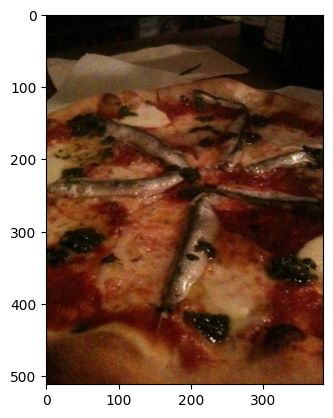

In [9]:
# Get Image Classs, thats the name of the directory
from torchvision.io import decode_image
img = decode_image(random_image_path)
plt.imshow(img.permute(1,2,0)) # Need to change as Pytorch puts color channels first


# 3. Transforming Data
We can probably use the toTensor to convert all the images in the folder to Tensors. Then we make a data loader with all the Data Set

In [10]:
# We wanna trasform our Data into a Data Set and then into a loder


In [11]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [12]:
# We create a Function with a few transforms, we can use a Compose for this
data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()

])

In [13]:
# We will use ImageFolder Data Set to load our data

In [14]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,transform=data_transform,target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,transform=data_transform,target_transform=None)

In [15]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: Data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

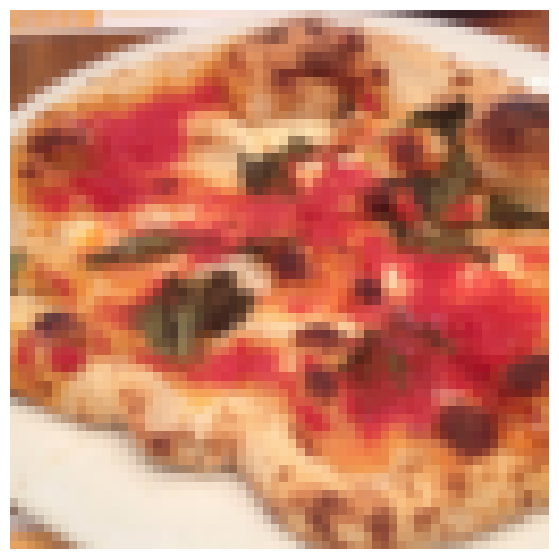

In [17]:
plt.figure(figsize=(10,7))
plt.axis("off")
plt.imshow(train_data[8][0].permute(1,2,0).numpy())

# Creating our Data Loader

In [18]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers = os.cpu_count())
test_dataloader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False,num_workers = os.cpu_count())
os.cpu_count()

2

# Creating a custom Data Set Class

 Loading Image Data with a custom Data Set so we can practice
 1. Want to be able to load images
 2. Want to be able to have all the classes

 Pros
 - Can create a data set for anything
 - Not limited to Pytorch Pre-Build Data Set functions

 Cons
 - Even Thoguh you could create a data set of almost anything it doesnt mean it will work
 - Using a custo data set is harder and needs more code that can be prone to errors

In [19]:
import os
import pathlib
from PIL import Image
from torch.utils.data import Dataset
from typing import Tuple, Dict, List
from torchvision import transforms

In [20]:
target_directory = train_dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])

In [21]:
class_names_found

['pizza', 'steak', 'sushi']

In [22]:
def find_classes(directory:str):
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"Couldnt find any classes in {directory}... Please check file structure")
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [23]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [24]:
class CustomDataSet(Dataset):
  def __init__(self,targ_dir:str, transform=None):
    # Create the paths for the files
    self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Create transform
    self.transform = transform
    # Create classes and attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)


  def load_image(self,index):
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self):
    return len(self.paths)


  # Needs to ovre write get item to create a custom data set

  def __getitem__(self,index:int) -> Tuple[torch.Tensor,int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx



In [25]:
train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
]
)

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [26]:
train_data_custom = CustomDataSet(targ_dir = train_dir,
                                  transform = train_transform)

In [27]:
test_data_custom = CustomDataSet(targ_dir = test_dir,
                                 transform = test_dir)

In [28]:
len(train_data_custom)

225

# Starting With Model Training and State of the Art Augmentation

In [29]:
# New Train transform
train_transform = transforms.Compose([transforms.Resize(size=(224,224,)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
                                      ])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
                      transforms.ToTensor()
])

In [30]:

class TinyVGG(nn.Module):
  def __init__(self,
               input_shape,
               hidden_units,
               output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)

    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)

    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=1690,
                  out_features=output_shape)
    )


  def forward(self,x,test=False):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [31]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)

In [32]:
image_batch, label_batch = next(iter(train_dataloader))

In [33]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

In [34]:
summary(model_0,input_size=[1,3,64,64])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

# Training Loop and Testing Loop


In [35]:
EPOCHS = 10
LR = 0.001
EPOCH_LIST = []
LOSS_LIST = []
loss_f = torch.nn.CrossEntropyLoss()


In [36]:
# Importing Torch metrics

try:
  import torchmetrics
except:
  !pip install torchmetrics


In [37]:
from torchmetrics import F1Score
from torchmetrics import Accuracy
f1 = F1Score(task="multiclass", num_classes=3).to(device)
accuracy = Accuracy(task="multiclass",num_classes=3).to(device)



In [38]:
torch.cuda.manual_seed = 42
def train_step(model,
               dataloader,
               loss_f,
               optimizer):
  model.train()
  train_loss, train_f1 = 0.0,0.0
  train_acc = 0.0
  for batch, (X,y) in enumerate(dataloader):

    X, y = X.to(device),y.to(device)
    y_pred = model(X)
    loss = loss_f(y_pred, y)
    # Accumulating Loss
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_f1 += f1(y_pred,y).item()
    train_acc += accuracy(y_pred,y).item()

    # Calculate Accuracy
  train_loss, train_f1 = train_loss / len(dataloader) , train_f1 / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_f1, train_acc



In [39]:
def test_step(model,
              dataloader,
              loss_f):
  model.eval()
  test_loss, test_f1 = 0,0
  test_acc = 0.0
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X,y = X.to(device),y.to(device)
      y_pred = model(X)
      loss = loss_f(y_pred,y)
      test_loss += loss.item()
      test_f1 += f1(y_pred,y).item()
      test_acc += accuracy(y_pred,y).item()

    test_loss, test_f1 = test_loss / len(dataloader), test_f1 / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss,test_f1, test_acc






In [40]:
from tqdm.auto import tqdm

def train(model,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_f,
          epochs):

    results = {"train_loss": [],
               "train_f1": [],
               "test_loss": [],
               "test_f1": [],
               "test_acc": [],
               "train_acc": []
               }
    for epoch in tqdm(range(epochs)):
      train_loss, train_f1,train_acc = train_step(model=model,
                                         dataloader=train_dataloader,
                                         optimizer = optimizer,
                                         loss_f = loss_f)
      test_loss, test_f1,test_acc = test_step(model=model,
                                     dataloader=test_dataloader,
                                     loss_f = loss_f
                                     )

      print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train F1: {train_f1} | Train Acc: {train_acc}| Test Loss: {test_loss} | Test F1 : {test_f1} | Test Acc: {test_acc}")

      results["train_f1"].append(train_f1)
      results["train_loss"].append(train_loss)
      results["test_loss"].append(test_loss)
      results["test_f1"].append(test_f1)
      results["test_acc"].append(test_acc)
      results["train_acc"].append(train_acc)

    return results




In [41]:
torch.cuda.manual_seed = 42
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
LR = 0.001
EPOCHS = 20
opt = torch.optim.Adam(params = model_0.parameters(),lr = LR,weight_decay=1e-5)
results = train(model=model_0,
      train_dataloader = train_dataloader,
      test_dataloader = test_dataloader,
      epochs = EPOCHS,
      optimizer = opt,
      loss_f = loss_f)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.0992468893527985 | Train F1: 0.41015625 | Train Acc: 0.41015625| Test Loss: 1.1076157490412395 | Test F1 : 0.2604166666666667 | Test Acc: 0.2604166666666667
Epoch: 1 | Train Loss: 1.0861957669258118 | Train F1: 0.42578125 | Train Acc: 0.42578125| Test Loss: 1.1236803929011028 | Test F1 : 0.2604166666666667 | Test Acc: 0.2604166666666667
Epoch: 2 | Train Loss: 1.118175446987152 | Train F1: 0.3046875 | Train Acc: 0.3046875| Test Loss: 1.1291912992795308 | Test F1 : 0.2604166666666667 | Test Acc: 0.2604166666666667
Epoch: 3 | Train Loss: 1.1134591847658157 | Train F1: 0.3046875 | Train Acc: 0.3046875| Test Loss: 1.1237483421961467 | Test F1 : 0.2604166666666667 | Test Acc: 0.2604166666666667
Epoch: 4 | Train Loss: 1.102078378200531 | Train F1: 0.3046875 | Train Acc: 0.3046875| Test Loss: 1.104236324628194 | Test F1 : 0.2604166666666667 | Test Acc: 0.2604166666666667
Epoch: 5 | Train Loss: 1.0967526584863663 | Train F1: 0.4453125 | Train Acc: 0.4453125| Test Loss: 

In [42]:
from torchmetrics import ConfusionMatrix
matrix = ConfusionMatrix(task="multiclass",num_classes = 3).to(device)

In [43]:
conf_matrix_preds = []
conf_matrix_y = []
for x,y in test_dataloader:
  model_0.eval()
  with torch.inference_mode():
    conf_matrix_y.append(y)
    conf_matrix_preds.append(model_0(x.to(device)))


In [44]:
matrix = matrix.to(device)
matrix(torch.cat(conf_matrix_preds).to(device),torch.cat(conf_matrix_y).to(device))

tensor([[ 3,  3, 19],
        [ 1, 11,  7],
        [ 5,  2, 24]], device='cuda:0')

In [45]:
def plot_loss_curves(results):
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]
  train_acc = results["train_acc"]
  test_acc = results["test_acc"]

  train_epochs = range(len(train_loss))
  test_epochs = range(len(test_loss))
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(train_epochs, train_loss, label = "Train Loss")
  plt.plot(test_epochs, test_loss, label = "Test Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(train_epochs,train_acc,label = "Train Accuracy")
  plt.plot(test_epochs, test_acc, label = "Test Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()



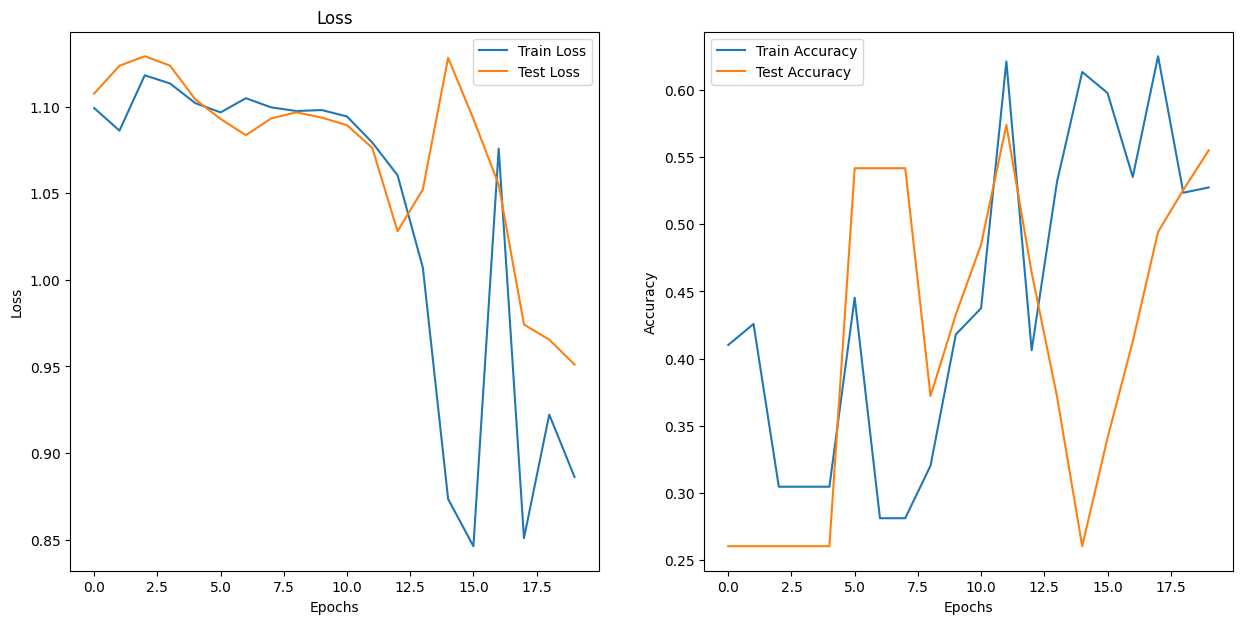

In [46]:
plot_loss_curves(results)

# Some Comments
Its very interesting to see how the Randomness is impacting my model, sometimes it will have a great performance but sometimes it will be stuck on a Local Minima, to solve for this ill just make a seed for it. A LR of 0.0001 seems to be the best even if its still with a High Bias

I forgot to add Non Inference when its testing so maybe regularization is being applied, ok that was stupid

Definitely More Epochs is improving performance but overfitting seems to be a big issue here.

With 20 epochs we get a 70% accuracy, not too bad, not too bad, but it can be better, we need human Performance here.

Probably should do a Early Stop


# Model 1 and Data Augmentation
Will try more data augmentation to improve my Actual Model.


In [47]:
train_transform_trivial = transforms.Compose([

    transforms.Resize(size=(64,64)),


    transforms.RandomResizedCrop(64, scale=(0.8, 1.0), ratio=(0.9, 1.1)),


    transforms.RandomHorizontalFlip(),


    transforms.RandomRotation(degrees=15),


    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),


    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),


    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),


    transforms.RandomGrayscale(p=0.1),


    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [48]:
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_augmented = datasets.ImageFolder(root=test_dir,
                                           transform=test_transform)

In [49]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        shuffle=True,
                                        batch_size = BATCH_SIZE,
                                        num_workers = NUM_WORKERS)

test_dataloader_augmented = DataLoader(dataset=test_data_augmented,
                                       shuffle= False,
                                       batch_size = BATCH_SIZE,
                                       num_workers = NUM_WORKERS)

In [53]:
LR_1 = 0.001
EPOCHS_1 = 20
class TinyVGG_1(nn.Module):
  def __init__(self,
               input_shape,
               hidden_units,
               output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2,
                     )

    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2,
                    )

    )


    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                 ),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)

    )

    self.classifier = nn.Sequential(
        nn.Flatten(),

        nn.Linear(in_features=1568,
                  out_features=output_shape)
    )


  def forward(self,x,test=False):
    return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))


model_1 = TinyVGG_1(input_shape=3,hidden_units=32,output_shape=3).to(device)
opt_1 = torch.optim.Adam(params=model_1.parameters(),
                         lr=LR_1,
                         weight_decay = 1e-5)
loss_fn = nn.CrossEntropyLoss()

model_1_results = train(model=model_1,
                        train_dataloader= train_dataloader_augmented,
                        test_dataloader = test_dataloader_augmented,
                        loss_f= loss_fn,
                        optimizer=opt_1,
                        epochs = EPOCHS_1)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.085346631705761 | Train F1: 0.53125 | Train Acc: 0.53125| Test Loss: 1.0818274815877278 | Test F1 : 0.5416666666666666 | Test Acc: 0.5416666666666666
Epoch: 1 | Train Loss: 0.9764422848820686 | Train F1: 0.5234375 | Train Acc: 0.5234375| Test Loss: 1.0886746644973755 | Test F1 : 0.28125 | Test Acc: 0.28125
Epoch: 2 | Train Loss: 1.0128663703799248 | Train F1: 0.47265625 | Train Acc: 0.47265625| Test Loss: 0.9751855532328287 | Test F1 : 0.4943181872367859 | Test Acc: 0.4943181872367859
Epoch: 3 | Train Loss: 1.0356524586677551 | Train F1: 0.46875 | Train Acc: 0.46875| Test Loss: 1.241554896036784 | Test F1 : 0.32102272907892865 | Test Acc: 0.32102272907892865
Epoch: 4 | Train Loss: 0.9863191694021225 | Train F1: 0.46484375 | Train Acc: 0.46484375| Test Loss: 1.1687828302383423 | Test F1 : 0.3541666666666667 | Test Acc: 0.3541666666666667
Epoch: 5 | Train Loss: 0.9403484463691711 | Train F1: 0.5859375 | Train Acc: 0.5859375| Test Loss: 1.0640744964281719 | Test F

Overfitting is still very Extreme, trying a dropout layer.
Greater Data Augmentation got to a big improvement, still underperfomming a lot for a bigger Neural Network
Modle with data augmentatnion is doing worst than the other model, it looks like there is not enough data.
The overfitting is so big i think the Model 1 is way too big for this simpler of a data set
Data Augmentation and bigger model made the model overfit more

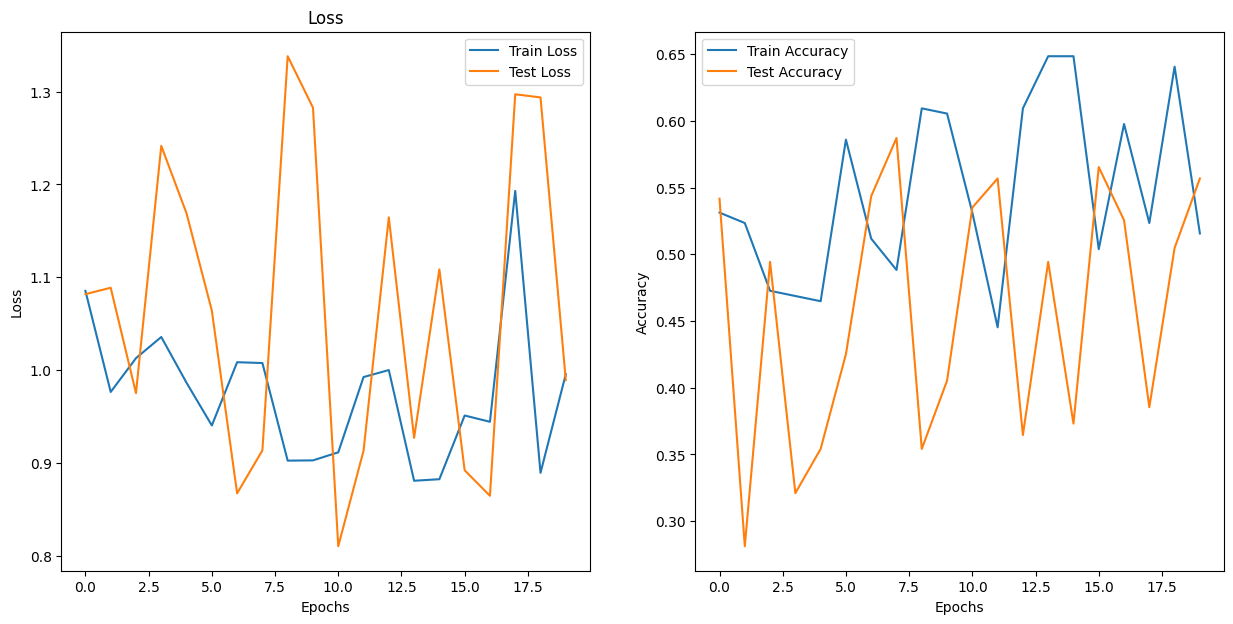

In [54]:
plot_loss_curves(model_1_results)

Thats very bad, i think i need more Data for this model to be better for sure. Will try it a last time
This is so shit lol

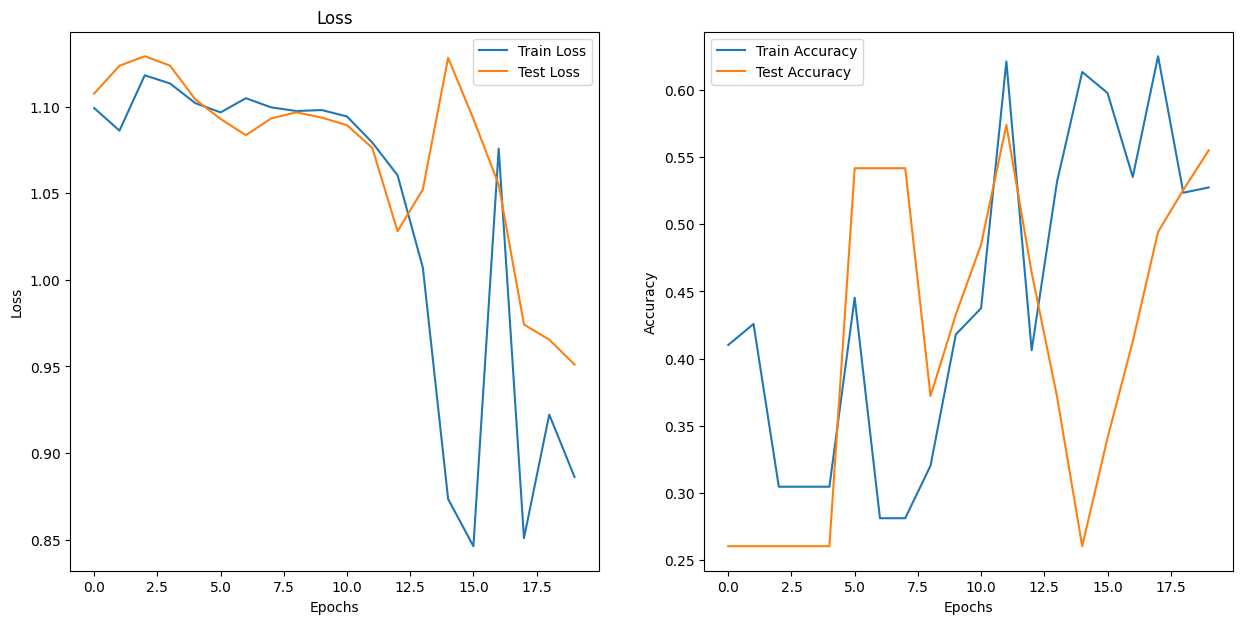

In [55]:
plot_loss_curves(results)

Their accuracy wasnt too different what is surprising considering the Data Augmentation i did for model 1 and how much bigger it was. Data Science is interesting

# Final Thoughts
Model is not big enough for this "complicated of a Data Set", ill try to reimplement it in a few days with the FOOD 101 data set instead.

It was still a good Data to implement because i got a lot of experience with it, next step is to go modular.